In [51]:
import numpy as np
import scipy
import scipy.linalg
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib
import matplotlib.pyplot as plt

# matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

In [53]:
def HankelMatrix(X, L):
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [54]:
def Svd(H, verbose=False):
    U, s, VT = np.linalg.svd(H)
    if verbose:
        print(s[:5])
    return U, s, VT

In [55]:
def FindKnnIdx(H, t, n_neighbors, verbose=False):
    # H_y = HankelMatrix(Y, L)
    # U, s, VT = Svd(H, verbose)
    # Uy, sy, VTy = np.linalg.svd(H_y)
    
    norm_list = np.array([np.linalg.norm(row - H[t]) for row in H])
    knn_idx = norm_list.argsort()[:n_neighbors + 1]
    
    return knn_idx

In [56]:
def Projection(U, s, V):
    print(U.shape, s.shape, V.shape)
    L = V.shape[1]
    S = np.zeros((U.shape[0], L))
    S[:L, :L] = np.diag(s)
    
    return U.dot(S)

In [57]:
def PlotTsWithKnn(X, knn_idx, t_max=None, savefig=False, filename=None):
    plt.figure(figsize=(16, 6))

    plot_idx = []
    for idx in knn_idx:
        if t_max is not None and idx < t_max or t_max is None:
            plot_idx.append(idx)
            
    print(X.shape)
    print(plot_idx)
    if t_max is None:
        right = X.shape[0]
    elif t_max > X.shape[0]:
        right = X.shape[0]
    else:
        right = t_max
        
    
    plt.plot(X[0 : right], zorder=0)
    plt.scatter(plot_idx, X[plot_idx], color='red', zorder=1)
    plt.scatter(plot_idx[0], X[plot_idx[0]], color='black', zorder=1)

    plt.xticks(size=14)
    plt.yticks(size=14)
    
    if savefig and filename is not None:
        plt.savefig(filename)

    plt.show()

In [58]:
def PlotKnnOnPhaseTrajectories(Pr_list, savefig=False, filename=None):
    n = len(Pr_list)
    fig, ax = plt.subplots(1, n, figsize=(8 * n, 6))

    for i, Pr in enumerate(Pr_list):
        coords, knn_idx, title, idx, lims = Pr
        knn_pr = coords[knn_idx]
        ax[i].plot(coords[:, idx[0]][lims[0]:lims[1]], coords[:, idx[1]][lims[0]:lims[1]], zorder=0, lw=1)

        # ax[i].plot(coords[:, 1][:400], coords[:, 2][:400], zorder=0)
    
        ax[i].scatter(knn_pr[:, idx[0]], knn_pr[:, idx[1]], 
                      color='red', zorder=1, facecolors='none', s=80, lw=2)
        ax[i].scatter(knn_pr[0, idx[0]], knn_pr[0, idx[1]], 
                      color='black', zorder=2, facecolors='none', s=80, lw=2)
        
        ax[i].set_xlabel('$y_1$', fontsize=18)
        ax[i].set_ylabel('$y_2$', fontsize=18)
        ax[i].set_title(str(len(knn_idx)) + ' neighbors, ' + title, fontsize=20)

    plt.setp(ax[0].get_xticklabels(), fontsize=14)
    plt.setp(ax[1].get_xticklabels(), fontsize=14)

    if savefig and filename is not None:
        plt.savefig(filename)
    plt.show()

### Фазовые траектории для искусственных рядов

In [16]:
N = 4000
N = 4000

t_max = 400

x_ampl = 2
x_shift = 0.3

y_scale = 2
y_shift = 0.5

np.random.seed(42)
x = np.sin(np.linspace(0, t_max, N + 1)) + 2 * np.sin(np.linspace(0, t_max, N + 1) / 2) * 0.4 + \
    np.random.randn(N + 1) * 0.3
y = np.sin(np.linspace(0, t_max, N + 1) * y_scale + y_shift) + np.random.randn(N + 1) * 0.25

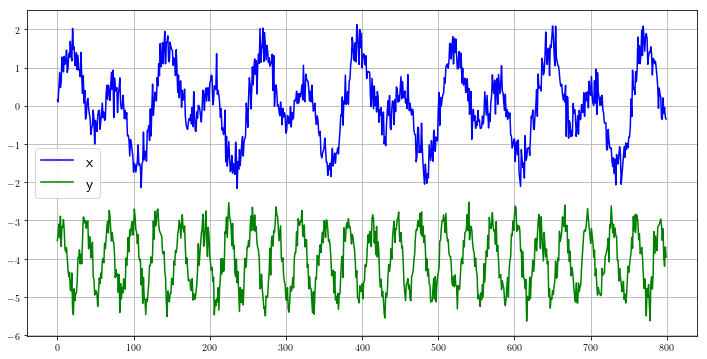

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(x[:N // 5], label='x', color='blue')
plt.plot(y[:N // 5] - 4, label='y', color='green')

plt.grid()
plt.legend(fontsize=16)
plt.show()

(4001,)
[15, 1775, 267, 1650, 769, 268, 2404, 771, 2405, 1777, 2402, 265, 1774, 770, 1271, 266, 1649, 141]


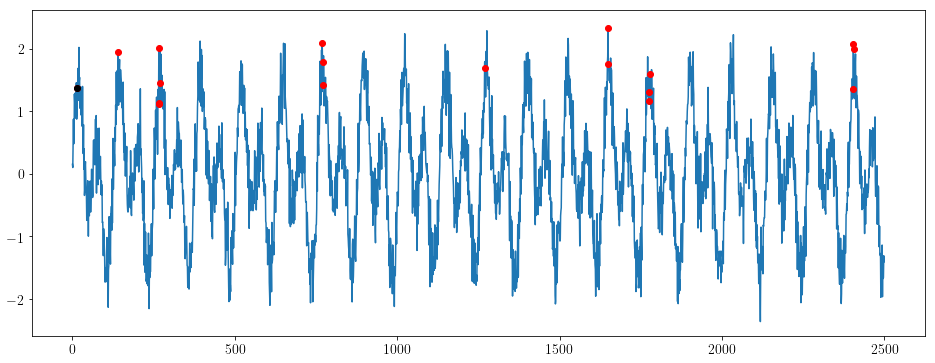

In [28]:
L = 100

H_X = HankelMatrix(x, L)
H_Y = HankelMatrix(y, L)

X_knn_idx = FindKnnIdx(H_X, t=15, n_neighbors=24)
PlotTsWithKnn(x, X_knn_idx, t_max=2500, savefig=False, filename='../text/pictures/generated_data/X_sin_knn.eps')

In [19]:
X_svd_data = Svd(H_X, verbose=True)
Y_svd_data = Svd(H_Y, verbose=True)

Pr_x = Projection(*X_svd_data)
Pr_y = Projection(*Y_svd_data)

[325.54372655 323.22865677 269.13959617 190.98477391  21.49636225]
[320.8485117  306.08156744  18.52498082  18.5056355   18.18143843]
(3902, 3902) (100,) (100, 100)
(3902, 3902) (100,) (100, 100)


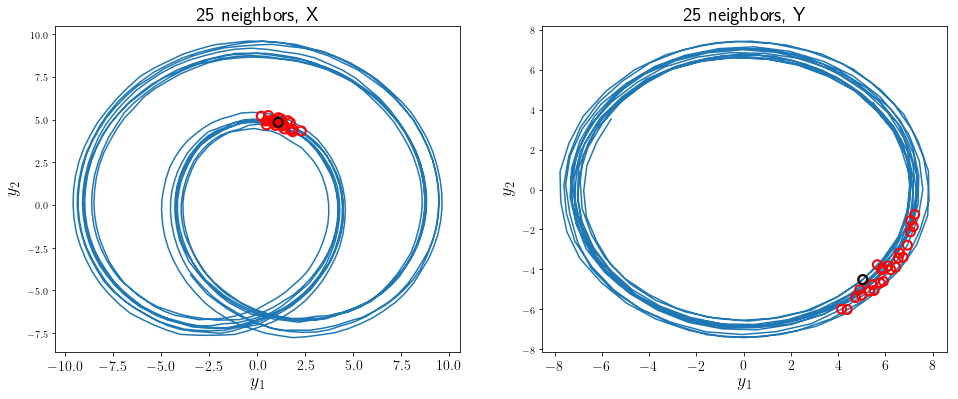

In [26]:
PlotKnnOnPhaseTrajectories([(Pr_x, X_knn_idx, 'X', [0, 1], [0, 1000]), 
                            (Pr_y, X_knn_idx, 'Y', [0, 1], [0, 400])],
                           savefig=False, filename='../text/pictures/generated_data/phase_tr_by_X.eps')

(4001,)
[20, 1088, 114, 334, 83, 239, 1685, 365, 962, 1120, 1464, 679, 1057, 2220, 2282, 428, 1245, 2062, 554]


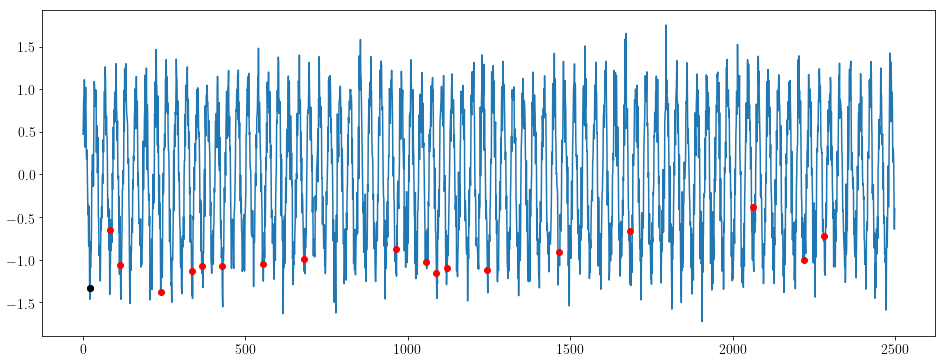

In [29]:
Y_knn_idx = FindKnnIdx(H_Y, t=20, n_neighbors=24)
PlotTsWithKnn(y, Y_knn_idx, t_max=2500, savefig=False, filename='../text/pictures/generated_data/Y_sin_knn.eps')

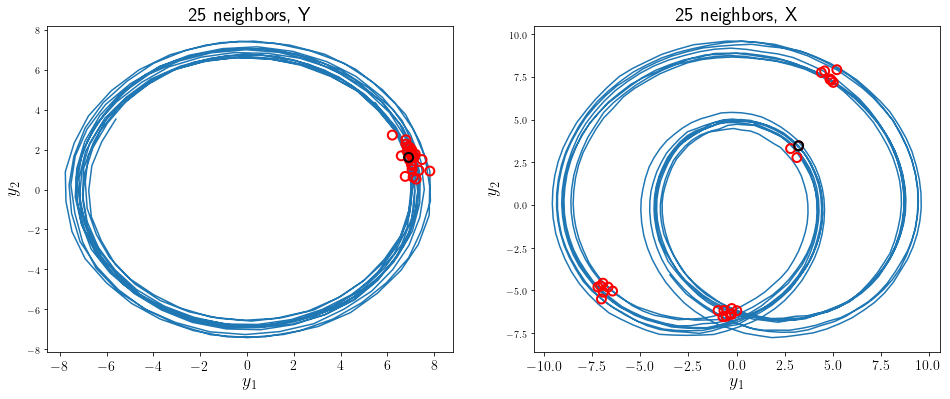

In [31]:
PlotKnnOnPhaseTrajectories([(Pr_y, Y_knn_idx, 'Y', [0, 1], [0, 400]), 
                            (Pr_x, Y_knn_idx, 'X', [0, 1], [0, 1000])], 
                           savefig=True, filename='../text/pictures/generated_data/phase_tr_by_Y.eps')

### Реальные данные

In [114]:
def MakeStationary(ts):
    new_ts = []
    for i in range(1, len(ts)):
        new_ts.append(ts[i] - ts[i - 1])
    return new_ts

In [115]:
def crosscorr(x, y, lag=0):
    return x.corr(y.shift(lag))

In [116]:
data = pd.read_csv('../data/EnergyConsumption.csv').iloc[:, 3:]
day_len_data = pd.read_csv('../data/day_len.csv').iloc[:, 3]

In [117]:
print(data.shape, day_len_data.shape)
data.head()

(8760, 2) (365,)


,ConsumprionMWtH,TemperatureC
0,1289.617859,-10.676569
1,1265.573853,-12.041959
2,1273.188232,-13.198006
3,1279.703979,-13.999279
4,1292.839539,-14.782819


In [118]:
Z = []

for i in range(day_len_data.shape[0]):
    length = day_len_data.iloc[i]
    
    for j in range(24):
        Z.append(length)
        
Z = np.array(Z)

mean = Z.mean()
std = Z.std()

Z = (Z - mean) / std

In [119]:
scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

In [120]:
X = np.array(scaled_data[:, 0])
Y = np.array(scaled_data[:, 1])

In [121]:
left = 0
right = X.shape[0]

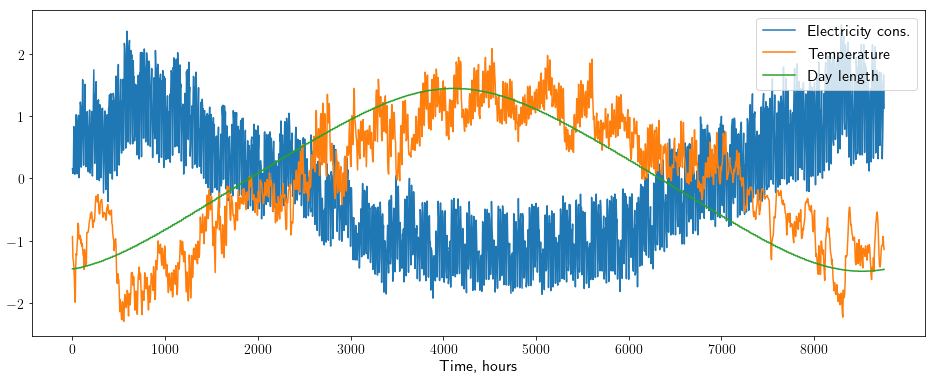

In [122]:
plt.figure(figsize=(16, 6))

plt.plot(range(0, X.shape[0], 5), X[::5], label='Electricity cons.')
plt.plot(range(0, Y.shape[0], 5), Y[::5], label='Temperature')
plt.plot(range(0, Z.shape[0], 5), Z[::5], label='Day length')

plt.xlabel('Time, hours', fontsize=16)
plt.xticks(range(0, X.shape[0], 1000), size=14)
plt.yticks(size=14)

plt.legend(loc=1, fontsize=16)
# plt.savefig('../text/pictures/energy_temp/energy_temp_daylen_ts.eps')
plt.show()

In [123]:
cross_corr_list = []

for i in range(0, len(Y) - 100):
    cross_corr_list.append(crosscorr(pd.Series(Y), pd.Series(Z), i))

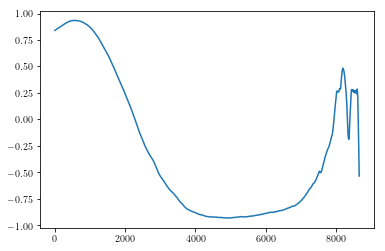

In [124]:
plt.plot(cross_corr_list)
plt.show()

In [125]:
shift = np.argmax(cross_corr_list)

In [126]:
Y_new = []

for i in range(shift, len(Y)):
    Y_new.append(Y[i] - Z[i - shift])
    
Y_new = np.array(Y_new)
Y = Y_new

In [127]:
X = np.array(MakeStationary(X[shift:]))
Y = np.array(MakeStationary(Y))

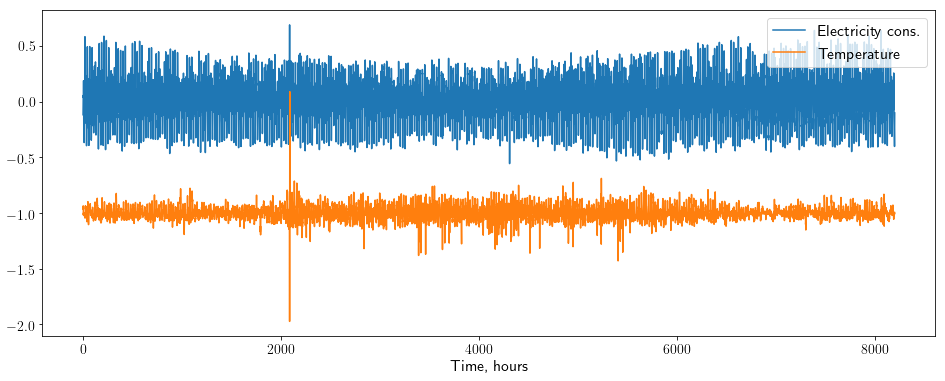

In [128]:
plt.figure(figsize=(16, 6))

plt.plot(X, label='Electricity cons.')
plt.plot(Y - 1, label='Temperature')

plt.xlabel('Time, hours', fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.legend(loc=1, fontsize=16)
plt.show()

In [129]:
left = 3000
right = 3400

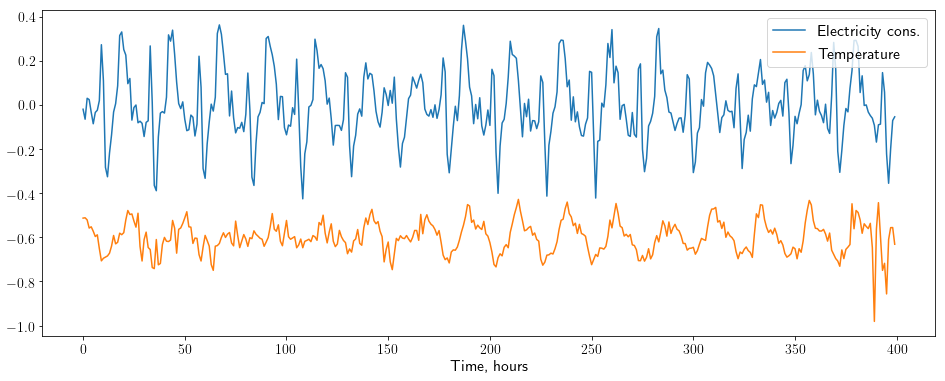

In [130]:
plt.figure(figsize=(16, 6))

plt.plot(X[left:right], label='Electricity cons.')
plt.plot(Y[left:right] - 0.6, label='Temperature')

plt.xlabel('Time, hours', fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.legend(loc=1, fontsize=16)
# plt.savefig('../text/pictures/energy_temp/energy_temp_ts.eps')
plt.show()

In [144]:
N = X.shape[0]
L = 170

In [145]:
H_X = HankelMatrix(X, L)
H_Y = HankelMatrix(Y, L)

In [146]:
X_svd_data = Svd(H_X, verbose=True)
Y_svd_data = Svd(H_Y, verbose=True)

Pr_x = Projection(*X_svd_data)
Pr_y = Projection(*Y_svd_data)

del X_svd_data, Y_svd_data

[91.11393049 90.04725046 83.71879363 82.91058522 37.86564594]
[31.03344935 30.69053938 12.00980864 11.9154277   8.26738378]
(8030, 8030) (170,) (170, 170)
(8030, 8030) (170,) (170, 170)


#### Зависимость Y от X, находим соседей по X

In [147]:
X_knn_idx = FindKnnIdx(Pr_x[:, :2], t=400, n_neighbors=19)
# X_knn_idx = FindKnnIdx(H_X, t=400, n_neighbors=19)

(8199,)
[400, 256, 40, 424, 136, 232, 64, 88, 304, 376, 112, 16, 280, 208, 352, 328, 160, 784]


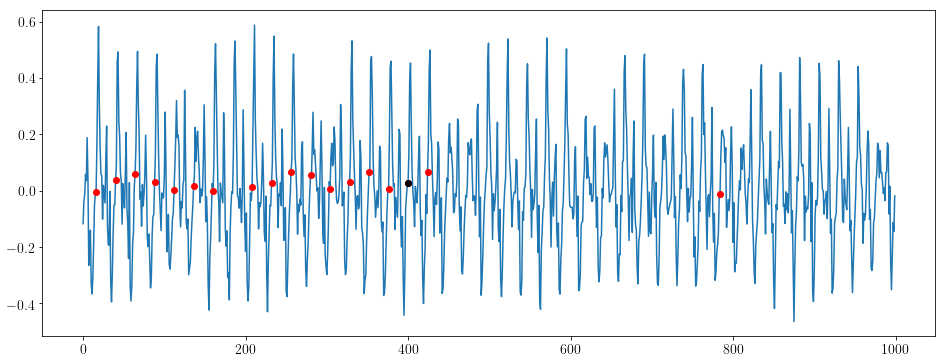

In [148]:
PlotTsWithKnn(X, X_knn_idx, t_max=1000, savefig=False, 
              filename='../text/pictures/energy_temp/X_knn_L'+ str(L) + '.eps')

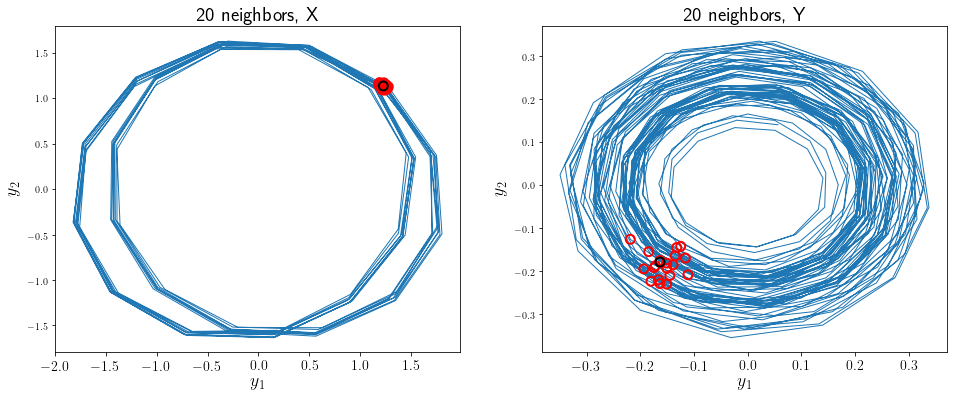

In [149]:
PlotKnnOnPhaseTrajectories([(Pr_x, X_knn_idx, 'X', [0, 1], [200, 400]),
                            (Pr_y, X_knn_idx, 'Y', [2, 3], [400, 1150])],
                           savefig=False, filename='../text/pictures/energy_temp/by_X_L' + str(L) + '_12.eps')

In [150]:
X_knn_idx = FindKnnIdx(Pr_x[:, 2:4], t=400, n_neighbors=19)
# X_knn_idx = FindKnnIdx(H_X, t=400, n_neighbors=19)

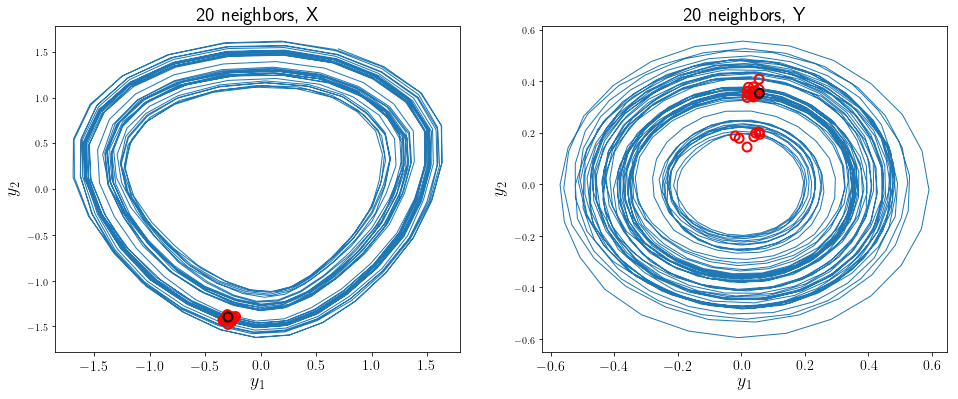

In [151]:
PlotKnnOnPhaseTrajectories([(Pr_x, X_knn_idx, 'X', [2, 3], [100, 1000]),
                            (Pr_y, X_knn_idx, 'Y', [0, 1], [100, 1400])],
                           savefig=False, filename='../text/pictures/energy_temp/by_X_L' + str(L) + '_24.eps')

#### Зависимость Y от X, находим соседей по X

In [152]:
Y_knn_idx = FindKnnIdx(Pr_y[:, 2:4], t=400, n_neighbors=19)
# Y_knn_idx = FindKnnIdx(H_Y, t=400, n_neighbors=19)

(8199,)
[400, 388, 424, 448, 316, 76, 148, 340, 328, 136, 640]


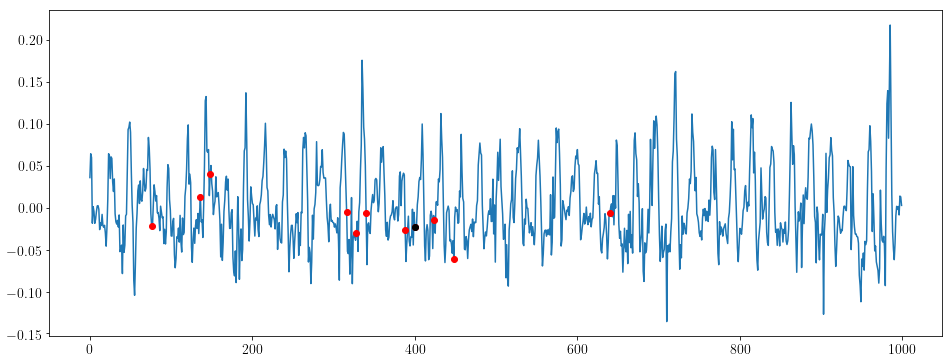

In [153]:
PlotTsWithKnn(Y, Y_knn_idx, t_max=1000, savefig=False, 
              filename='../text/pictures/energy_temp/Y_knn_L'+ str(L) + '.eps')

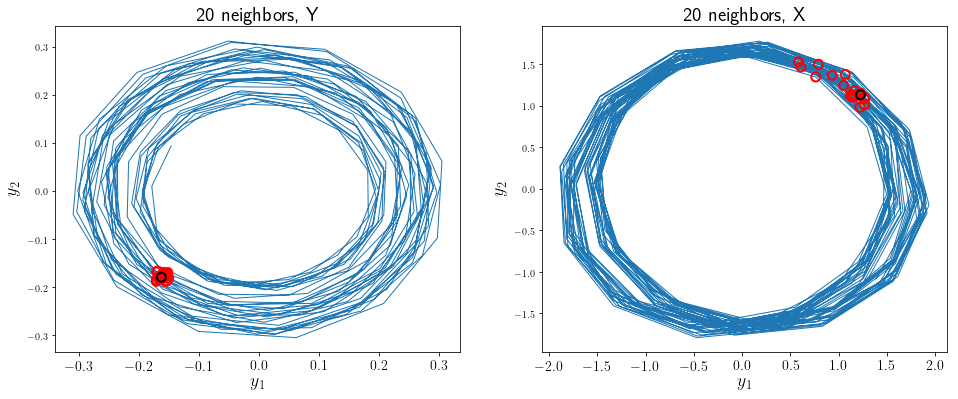

In [154]:
PlotKnnOnPhaseTrajectories([(Pr_y, Y_knn_idx, 'Y', [2, 3], [6100, 6500]), 
                            (Pr_x, Y_knn_idx, 'X', [0, 1], [6000, 6500])], 
                           savefig=False, filename='../text/pictures/energy_temp/by_Y_L' + str(L) + '_12.eps')

In [155]:
Y_knn_idx = FindKnnIdx(Pr_y[:, :2], t=400, n_neighbors=19)
# Y_knn_idx = FindKnnIdx(H_Y, t=400, n_neighbors=19)

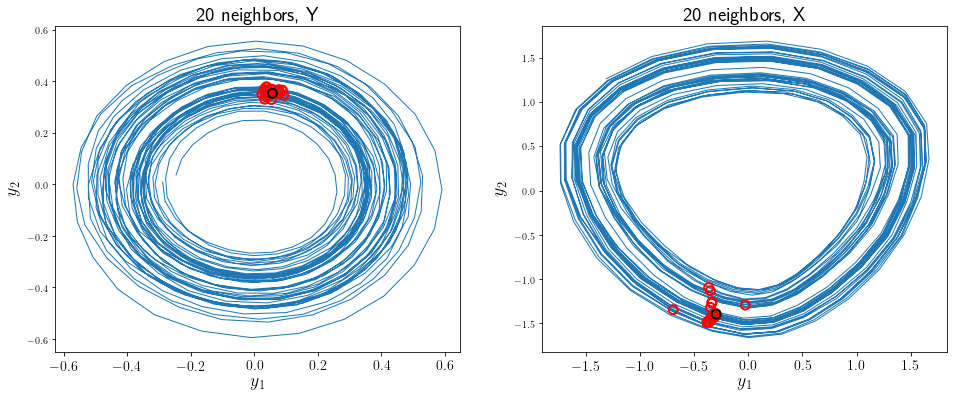

In [156]:
PlotKnnOnPhaseTrajectories([(Pr_y, Y_knn_idx, 'Y', [0, 1], [0, 1150]), 
                            (Pr_x, Y_knn_idx, 'X', [2, 3], [0, 1000])], 
                           savefig=False, filename='../text/pictures/energy_temp/by_Y_L' + str(L) + '_24.eps')

In [157]:
d = {}
t = 100
T = 12

def AddToDict(key, value):
    if key not in d:
        d[key] = []
    d[key].append(value)


for idx in Y_knn_idx[1:]:
    for shift in range(-5, 6):
        if (idx + shift - t) % T == 0:
            AddToDict(shift, idx)

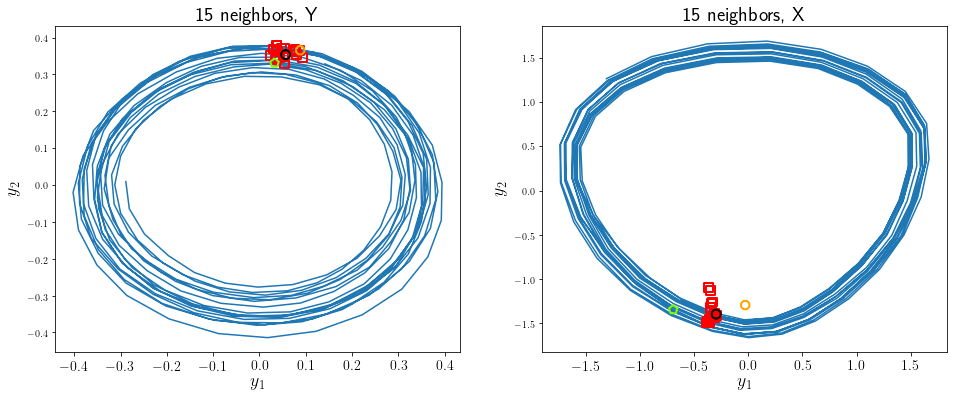

In [158]:
fit, ax = plt.subplots(1, 2, figsize=(16, 6))

# Y
idx = [0, 1]
lims = [0, 400]
ax[0].plot(Pr_y[:, idx[0]][lims[0]:lims[1]], 
           Pr_y[:, idx[1]][lims[0]:lims[1]], zorder=0)

ax[0].scatter(Pr_y[Y_knn_idx][0, idx[0]], Pr_y[Y_knn_idx][0, idx[1]], 
              color='black', zorder=2, facecolors='none', s=80, lw=2)

for shift, color, marker in zip(list(d.keys()), 
                                ['red', 'lawngreen', 'orange', 'indigo'], 
                                ['s', 'p', '8', 'v']):
    ax[0].scatter(Pr_y[d[shift]][:, idx[0]], Pr_y[d[shift]][:, idx[1]], 
                  color=color, zorder=1, facecolors='none', s=80, lw=2, marker=marker)
    
ax[0].set_xlabel('$y_1$', fontsize=18)
ax[0].set_ylabel('$y_2$', fontsize=18)
ax[0].set_title("15 neighbors, Y", fontsize=20)

# X
idx = [2, 3]
lims = [0, 400]
ax[1].plot(Pr_x[:, idx[0]][lims[0]:lims[1]], Pr_x[:, idx[1]][lims[0]:lims[1]], zorder=0)

ax[1].scatter(Pr_x[Y_knn_idx][0, idx[0]], Pr_x[Y_knn_idx][0, idx[1]], 
              color='black', zorder=2, facecolors='none', s=80, lw=2)

for shift, color, marker in zip(list(d.keys()), 
                                ['red', 'lawngreen', 'orange', 'indigo'], 
                                ['s', 'p', '8', 'v']):
    ax[1].scatter(Pr_x[d[shift]][:, idx[0]], Pr_x[d[shift]][:, idx[1]], 
                  color=color, zorder=1, facecolors='none', s=80, lw=2, marker=marker)

ax[1].set_xlabel('$y_1$', fontsize=18)
ax[1].set_ylabel('$y_2$', fontsize=18)
ax[1].set_title("15 neighbors, X", fontsize=20)


plt.setp(ax[0].get_xticklabels(), fontsize=14)
plt.setp(ax[1].get_xticklabels(), fontsize=14)

# plt.savefig('../text/pictures/energy_temp/by_Y_L' + str(L) + '_24_colored.eps')
plt.show()

In [159]:
def MeanDist(vectors):
    dist_list = [np.linalg.norm(vectors[0] - vec) for vec in vectors[1:]]
    return np.array(dist_list).mean()

In [160]:
N = X.shape[0]
L = 170

In [161]:
H_X = HankelMatrix(X, L)
H_Y = HankelMatrix(Y, L)

In [162]:
X_svd_data = Svd(H_X, verbose=True)
Y_svd_data = Svd(H_Y, verbose=True)

Pr_x = Projection(*X_svd_data)
Pr_y = Projection(*Y_svd_data)

del X_svd_data, Y_svd_data

[91.11393049 90.04725046 83.71879363 82.91058522 37.86564594]
[31.03344935 30.69053938 12.00980864 11.9154277   8.26738378]
(8030, 8030) (170,) (170, 170)
(8030, 8030) (170,) (170, 170)


In [164]:
import itertools

In [166]:
plot_Y = []
plot_X = []

In [167]:
K = 5


for k in range(1, K + 1):
    for comp_idx in itertools.combinations(range(0, K), k):
        X_knn_idx = FindKnnIdx(Pr_x[:, list(comp_idx)], t=400, n_neighbors=19)
        """
        results_by_X[comp_idx] = (MeanDist(Pr_x[X_knn_idx, :][:, list(comp_idx)]), 
                                  MeanDist(Pr_y[X_knn_idx, :][:, list(comp_idx)]))
        """
        plot_X.append((comp_idx, MeanDist(Pr_x[X_knn_idx, :][:, list(comp_idx)]) /\
                                MeanDist(Pr_y[X_knn_idx, :][:, list(comp_idx)])))
        
        Y_knn_idx = FindKnnIdx(Pr_y[:, list(comp_idx)], t=400, n_neighbors=19)
        plot_Y.append((comp_idx, MeanDist(Pr_y[Y_knn_idx, :][:, list(comp_idx)]) /\
                                MeanDist(Pr_x[Y_knn_idx, :][:, list(comp_idx)])))
        """
        results_by_Y[comp_idx] = (MeanDist(Pr_y[Y_knn_idx, :][:, list(comp_idx)]), 
                                  MeanDist(Pr_x[Y_knn_idx, :][:, list(comp_idx)]))"""

In [168]:
ticks = []

for pair in plot_X:
    key = ''
    for idx in pair[0]:
        key += str(idx) + ' '
    ticks.append(key)

In [169]:
plot_X = np.array(plot_X)
plot_Y = np.array(plot_Y)

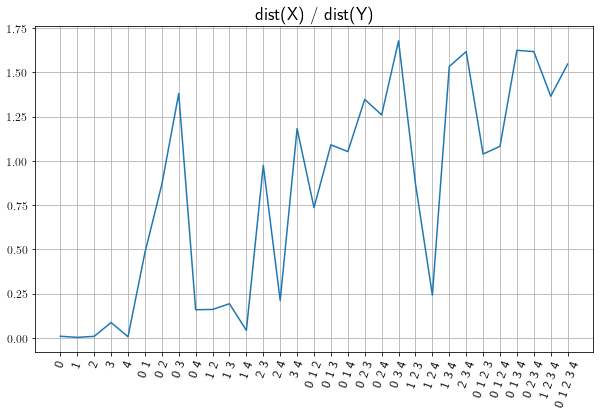

In [190]:
plt.figure(figsize=(10, 6))

plt.grid(zorder=0)
plt.plot(plot_X[:, 1], zorder=4)

plt.title('dist(X) / dist(Y)', fontsize=18)
plt.yticks(size=12)
plt.xticks(range(len(ticks)), ticks, rotation=70, size=13)

# plt.savefig('../text/pictures/energy_temp/diff_Pr_by_X.eps')
plt.show()

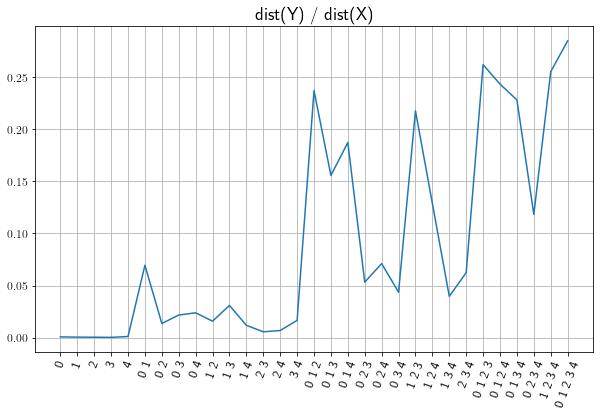

In [192]:
plt.figure(figsize=(10, 6))

plt.grid(zorder=0)
plt.plot(plot_Y[:, 1], zorder=4)

plt.title('dist(Y) / dist(X)', fontsize=18)
plt.yticks(size=12)
plt.xticks(range(len(ticks)), ticks, rotation=70, size=13)


# plt.savefig('../text/pictures/energy_temp/diff_Pr_by_Y.eps')
plt.show()

### Фазовые траектории для искусственных рядов

def HankelMatrix(X, L):
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

def Svd(H, verbose=False):
    U, s, VT = np.linalg.svd(H)
    if verbose:
        print(s[:5])
    return U, s, VT

def FindKnnIdx(H, t, n_neighbors, verbose=False):
    # H_y = HankelMatrix(Y, L)
    # U, s, VT = Svd(H, verbose)
    # Uy, sy, VTy = np.linalg.svd(H_y)
    
    norm_list = np.array([np.linalg.norm(row - H[t]) for row in H])
    knn_idx = norm_list.argsort()[:n_neighbors + 1]
    
    return knn_idx

def Projection(U, s, V):
    print(U.shape, s.shape, V.shape)
    L = V.shape[1]
    S = np.zeros((U.shape[0], L))
    S[:L, :L] = np.diag(s)
    
    return U.dot(S)

def PlotTsWithKnn(X, knn_idx, t_max=None, savefig=False, filename=None):
    plt.figure(figsize=(16, 6))

    plot_idx = []
    for idx in knn_idx:
        if t_max is not None and idx < t_max or t_max is None:
            plot_idx.append(idx)
            
    print(X.shape)
    print(plot_idx)
    if t_max is None:
        right = X.shape[0]
    elif t_max > X.shape[0]:
        right = X.shape[0]
    else:
        right = t_max
        
    
    plt.plot(X[0 : right], zorder=0)
    plt.scatter(plot_idx, X[plot_idx], color='red', zorder=1)
    plt.scatter(plot_idx[0], X[plot_idx[0]], color='black', zorder=1)

    plt.xticks(size=14)
    plt.yticks(size=14)
    
    if savefig and filename is not None:
        plt.savefig(filename)

    plt.show()

def PlotKnnOnPhaseTrajectories(Pr_list, savefig=False, filename=None):
    n = len(Pr_list)
    fig, ax = plt.subplots(1, n, figsize=(8 * n, 6))

    for i, Pr in enumerate(Pr_list):
        coords, knn_idx, title, idx, lims = Pr
        knn_pr = coords[knn_idx]
        ax[i].plot(coords[:, idx[0]][lims[0]:lims[1]], coords[:, idx[1]][lims[0]:lims[1]], zorder=0)

        # ax[i].plot(coords[:, 1][:400], coords[:, 2][:400], zorder=0)
        ax[i].scatter(knn_pr[:, idx[0]], knn_pr[:, idx[1]], 
                      color='red', zorder=1, facecolors='none', s=80, lw=2)
        ax[i].scatter(knn_pr[0, idx[0]], knn_pr[0, idx[1]], 
                      color='black', zorder=2, facecolors='none', s=80, lw=2)

        ax[i].set_xlabel('$y_1$', fontsize=18)
        ax[i].set_ylabel('$y_2$', fontsize=18)
        ax[i].set_title(str(len(knn_idx)) + ' neighbors, ' + title, fontsize=20)

    plt.setp(ax[0].get_xticklabels(), fontsize=14)
    plt.setp(ax[1].get_xticklabels(), fontsize=14)

    if savefig and filename is not None:
        plt.savefig(filename)
    plt.show()

N = 4000
N = 4000

t_max = 400

x_ampl = 2
x_shift = 0.3

y_scale = 2
y_shift = 0.5

np.random.seed(42)
x = np.sin(np.linspace(0, t_max, N + 1)) + 2 * np.sin(np.linspace(0, t_max, N + 1) / 2) * 0.4 + \
    np.random.randn(N + 1) * 0.3
y = np.sin(np.linspace(0, t_max, N + 1) * y_scale + y_shift) + np.random.randn(N + 1) * 0.25

plt.figure(figsize=(12, 6))
plt.plot(x[:N // 5], label='x', color='blue')
plt.plot(y[:N // 5] - 4, label='y', color='green')

plt.grid()
plt.legend(fontsize=16)
plt.show()

L = 100

H_X = HankelMatrix(x, L)
H_Y = HankelMatrix(y, L)

X_knn_idx = FindKnnIdx(H_X, t=15, n_neighbors=24)
PlotTsWithKnn(x, X_knn_idx, t_max=2500, savefig=False, filename='../text/pictures/generated_data/X_sin_knn.eps')

X_svd_data = Svd(H_X, verbose=True)
Y_svd_data = Svd(H_Y, verbose=True)

Pr_x = Projection(*X_svd_data)
Pr_y = Projection(*Y_svd_data)

PlotKnnOnPhaseTrajectories([(Pr_x, X_knn_idx, 'X', [0, 1], [0, 1000]), 
                            (Pr_y, X_knn_idx, 'Y', [0, 1], [0, 400])],
                           savefig=False, filename='../text/pictures/generated_data/phase_tr_by_X.eps')

Y_knn_idx = FindKnnIdx(H_Y, t=20, n_neighbors=24)
PlotTsWithKnn(y, Y_knn_idx, t_max=2500, savefig=False, filename='../text/pictures/generated_data/Y_sin_knn.eps')

PlotKnnOnPhaseTrajectories([(Pr_y, Y_knn_idx, 'Y', [0, 1], [0, 400]), 
                            (Pr_x, Y_knn_idx, 'X', [0, 1], [0, 1000])], 
                           savefig=False, filename='../text/pictures/generated_data/phase_tr_by_Y.eps')